In [1]:
import pyspark
from pyspark import SparkContext
from pyspark.sql.window import Window
from pyspark.sql import functions as F
from pyspark.sql import types as T

import json
import numpy as np

#Imports to enable visualizations
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline  

In [2]:
def rename_columns(df, list_of_tuples):
    for (old_col, new_col) in list_of_tuples:
        df = df.withColumnRenamed(old_col, new_col)
    return df

def read_hdfs_folder(sqlContext, folderpath):
    data_frame = sqlContext.read.format("com.databricks.spark.csv")\
        .option("header", "true")\
        .option("inferSchema", "true") \
        .option("nullValue", "-")\
        .load(folderpath)
        
    data_frame = rename_columns(
        data_frame,
        [
            ("cardNum18", "cardNum"),
            ("cardNum19", "userGender"),
        ]
    )
    
    date = "-".join(folderpath.split("/")[-2].split("_")[:3])

    data_frame = data_frame.withColumn("date", F.lit(date))
    data_frame = data_frame.withColumn("date", F.date_sub(F.col("date"),1))

    return data_frame

def read_buste_data_v3(sqlContext, filepath):
    data_frame = sqlContext.read.csv(filepath, header=True,
                                     inferSchema=True,nullValue="-")
    
    date = "-".join(filepath.split("/")[-2].split("_")[:3])

    data_frame = data_frame.withColumn("date", F.lit(date))
    data_frame = data_frame.withColumn("date", F.unix_timestamp(F.date_sub(F.col("date"),1),'yyyy-MM-dd'))
    
    return data_frame

def printdf(df,l=10):
    return df.limit(l).toPandas()

### Read BUSTE result Data

In [3]:
sc = SparkContext.getOrCreate()
sqlContext = pyspark.SQLContext(sc)

In [4]:
exp_data_folder_path = '/local/tarciso/masters/experiments/preliminary-exp/preliminary-exp-sample-data/buste-v3a/'

In [6]:
user_boardings = read_hdfs_folder(sqlContext, exp_data_folder_path + '/buste-output/2017_05_11_veiculos.csv/')

In [7]:
printdf(user_boardings)

,route,tripNum,shapeId,shapeSequence,shapeLat,shapeLon,distanceTraveledShape,busCode,gpsPointId,gpsLat,...,distanceToShapePoint,timestamp,stopPointId,problem,birthdate,cardTimestamp,lineName,cardNum,gender,date
0,901,8,2899,6191404,-25.426912,-49.279239,863.953,MC304,None,-25.426885,...,3.177324,12:00:18,26722,NO_PROBLEM,None,None,None,NaN,None,2017-05-10
1,901,8,2899,6191416,-25.425207,-49.279476,1069.936,MC304,None,-25.425250,...,6.342949,12:01:01,26638,NO_PROBLEM,None,None,None,NaN,None,2017-05-10
2,901,8,2899,6191429,-25.423221,-49.280815,1381.224,MC304,None,-25.423193,...,10.632870,12:02:36,26637,NO_PROBLEM,None,None,None,NaN,None,2017-05-10
3,901,8,2899,6191441,-25.422463,-49.284100,1723.696,MC304,None,NaN,...,NaN,12:03:51,32794,BETWEEN,None,None,None,NaN,None,2017-05-10
4,901,8,2899,6191457,-25.422289,-49.288080,2133.278,MC304,None,-25.422263,...,3.002426,12:04:50,32795,NO_PROBLEM,None,None,None,NaN,None,2017-05-10
5,901,8,2899,6191462,-25.422660,-49.289950,2325.793,MC304,None,-25.422646,...,10.770773,12:05:29,32796,NO_PROBLEM,12/07/98,12:05:42,STA. FELICIDADE,3694801.0,F,2017-05-10
6,901,8,2899,6191462,-25.422660,-49.289950,2325.793,MC304,None,-25.422646,...,10.770773,12:05:29,32796,NO_PROBLEM,29/08/66,12:06:25,STA. FELICIDADE,2265034.0,F,2017-05-10
7,901,8,2899,6191462,-25.422660,-49.289950,2325.793,MC304,None,-25.422646,...,10.770773,12:05:29,32796,NO_PROBLEM,02/05/98,12:06:19,STA. FELICIDADE,3736192.0,M,2017-05-10
8,901,8,2899,6191478,-25.421165,-49.292240,2642.556,MC304,None,-25.421143,...,6.142177,12:08:29,33681,NO_PROBLEM,06/07/02,12:09:35,STA. FELICIDADE,2444646.0,M,2017-05-10
9,901,8,2899,6191478,-25.421165,-49.292240,2642.556,MC304,None,-25.421143,...,6.142177,12:08:29,33681,NO_PROBLEM,02/10/03,12:09:21,STA. FELICIDADE,2444654.0,M,2017-05-10


In [8]:
user_boardings.printSchema()

root
 |-- route: string (nullable = true)
 |-- tripNum: integer (nullable = true)
 |-- shapeId: integer (nullable = true)
 |-- shapeSequence: integer (nullable = true)
 |-- shapeLat: double (nullable = true)
 |-- shapeLon: double (nullable = true)
 |-- distanceTraveledShape: double (nullable = true)
 |-- busCode: string (nullable = true)
 |-- gpsPointId: string (nullable = true)
 |-- gpsLat: double (nullable = true)
 |-- gpsLon: double (nullable = true)
 |-- distanceToShapePoint: double (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- stopPointId: integer (nullable = true)
 |-- problem: string (nullable = true)
 |-- birthdate: string (nullable = true)
 |-- cardTimestamp: string (nullable = true)
 |-- lineName: string (nullable = true)
 |-- cardNum: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- date: date (nullable = true)



In [9]:
total_boardings = user_boardings.count()
print total_boardings

637707


In [10]:
total_passengers = user_boardings.select('cardNum').distinct().count()
print total_passengers

107689


### Removing rows with missing data

In [11]:
filtered_boardings = user_boardings.na.drop(subset=["route","busCode","tripNum","stopPointId","timestamp","shapeLon","shapeLat","cardNum","cardTimestamp"])

In [12]:
total_filtered_boardings = filtered_boardings.count()
print total_filtered_boardings, "(", 100*(total_filtered_boardings/float(total_boardings)), "%)"
printdf(filtered_boardings)

140033 ( 21.9588306228 %)


,route,tripNum,shapeId,shapeSequence,shapeLat,shapeLon,distanceTraveledShape,busCode,gpsPointId,gpsLat,...,distanceToShapePoint,timestamp,stopPointId,problem,birthdate,cardTimestamp,lineName,cardNum,gender,date
0,901,8,2899,6191462,-25.422660,-49.289950,2325.793,MC304,None,-25.422646,...,10.770773,12:05:29,32796,NO_PROBLEM,12/07/98,12:05:42,STA. FELICIDADE,3694801,F,2017-05-10
1,901,8,2899,6191462,-25.422660,-49.289950,2325.793,MC304,None,-25.422646,...,10.770773,12:05:29,32796,NO_PROBLEM,29/08/66,12:06:25,STA. FELICIDADE,2265034,F,2017-05-10
2,901,8,2899,6191462,-25.422660,-49.289950,2325.793,MC304,None,-25.422646,...,10.770773,12:05:29,32796,NO_PROBLEM,02/05/98,12:06:19,STA. FELICIDADE,3736192,M,2017-05-10
3,901,8,2899,6191478,-25.421165,-49.292240,2642.556,MC304,None,-25.421143,...,6.142177,12:08:29,33681,NO_PROBLEM,06/07/02,12:09:35,STA. FELICIDADE,2444646,M,2017-05-10
4,901,8,2899,6191478,-25.421165,-49.292240,2642.556,MC304,None,-25.421143,...,6.142177,12:08:29,33681,NO_PROBLEM,02/10/03,12:09:21,STA. FELICIDADE,2444654,M,2017-05-10
5,901,8,2899,6191478,-25.421165,-49.292240,2642.556,MC304,None,-25.421143,...,6.142177,12:08:29,33681,NO_PROBLEM,26/03/02,12:09:23,STA. FELICIDADE,3827916,M,2017-05-10
6,901,8,2899,6191522,-25.415511,-49.300494,3814.081,MC304,None,-25.415503,...,6.945394,12:13:04,33673,NO_PROBLEM,24/06/85,12:13:56,STA. FELICIDADE,3746744,F,2017-05-10
7,901,8,2899,6191522,-25.415511,-49.300494,3814.081,MC304,None,-25.415503,...,6.945394,12:13:04,33673,NO_PROBLEM,21/08/71,12:13:13,STA. FELICIDADE,2264165,F,2017-05-10
8,901,9,2257,6191276,-25.421376,-49.292242,5179.099,MC304,None,-25.421488,...,13.485546,12:39:05,33682,NO_PROBLEM,08/08/91,12:39:37,STA. FELICIDADE,3366188,F,2017-05-10
9,901,9,2257,6191294,-25.423379,-49.287627,5902.008,MC304,None,-25.423368,...,18.839048,12:43:13,26455,NO_PROBLEM,05/07/98,12:43:47,STA. FELICIDADE,3023810,F,2017-05-10


### Removing duplicated passenger data

In [13]:
filtered_boardings = filtered_boardings.dropDuplicates(['cardNum','date','cardTimestamp'])

In [14]:
non_duplicated_boardings = filtered_boardings.count()
print non_duplicated_boardings, "(", 100*(non_duplicated_boardings/float(total_boardings)), "%)"
printdf(filtered_boardings)

140031 ( 21.9585169992 %)


,route,tripNum,shapeId,shapeSequence,shapeLat,shapeLon,distanceTraveledShape,busCode,gpsPointId,gpsLat,...,distanceToShapePoint,timestamp,stopPointId,problem,birthdate,cardTimestamp,lineName,cardNum,gender,date
0,547,15,4125,6165607,-25.541827,-49.264612,4097.772,GA142,None,-25.541680,...,31.689760,05:53:33,31271,NO_PROBLEM,22/04/63,05:54:23,V. SÃO PEDRO,431802,F,2017-05-10
1,828,1,2941,4249004,-25.460141,-49.340811,9660.000,LA001,None,-25.460058,...,9.355352,06:06:58,34257,NO_PROBLEM,28/05/63,06:07:54,C.COMP/C.RASO,433069,F,2017-05-10
2,777,11,2195,4299895,-25.442293,-49.269757,1126.717,JC006,None,-25.442241,...,7.728910,17:59:39,32903,NO_PROBLEM,03/02/93,18:00:33,V. VELHA,444810,F,2017-05-10
3,658,1,2115,6642358,-25.491613,-49.349015,2871.251,JA027,None,-25.491595,...,3.681068,06:18:32,35720,NO_PROBLEM,28/07/71,06:19:29,C.RASO/CAIUÁ,624028,M,2017-05-10
4,332,26,1864,5605729,-25.474949,-49.194635,4197.070,DA300,None,-25.474938,...,7.856321,15:16:37,32457,NO_PROBLEM,04/04/68,15:17:35,ACRÓPOLE,742198,F,2017-05-10
5,628,2,2055,6035022,-25.544264,-49.315882,11215.314,HA016,None,-25.544026,...,40.477060,07:59:07,35163,NO_PROBLEM,06/03/89,07:59:30,CARBOMAFRA,768474,F,2017-05-10
6,050,2,1719,5305264,-25.476441,-49.321794,909.737,DR103,None,NaN,...,NaN,08:57:43,31638,BETWEEN,01/06/77,08:57:55,INTERBAIRROS V,810569,F,2017-05-10
7,812,4,2211,4166911,-25.418983,-49.351245,2163.377,BA022,None,NaN,...,NaN,07:19:16,30336,BETWEEN,04/02/81,07:19:29,MONTANA,811762,F,2017-05-10
8,614,4,2030,5808518,-25.451123,-49.252929,9972.134,GR405,None,-25.451110,...,4.154369,12:56:27,31749,NO_PROBLEM,20/09/66,12:57:31,FAZENDINHA/PUC,829222,M,2017-05-10
9,561,15,2005,6405261,-25.462226,-49.262185,3596.773,EC002,None,-25.462290,...,11.532125,18:59:00,31986,NO_PROBLEM,24/04/57,18:59:08,GUILHERMINA,846408,F,2017-05-10


### Removing single-trip users records

In [15]:
boarding_count = filtered_boardings.groupby('cardNum').count()

In [16]:
#Filtering only users with more than one ride per day
multiple_boardings = boarding_count.filter(F.col('count') > 1)

In [17]:
total_passengers = user_boardings.select('cardNum').distinct().count()
print "Total #Passengers:", total_passengers

Total #Passengers: 107689


In [18]:
passengers_mult_boardings = multiple_boardings.count()
prop_mult_boardings = 100*(passengers_mult_boardings)/total_passengers
print "Passengers with Multiple Boardings:", passengers_mult_boardings, "(", prop_mult_boardings, "%)" 
multiple_boardings.show()

Passengers with Multiple Boardings: 26687 ( 24 %)
+-------+-----+
|cardNum|count|
+-------+-----+
|3522158|    2|
|2298968|    2|
|3790541|    2|
|3821560|    2|
|3754400|    2|
|3639748|    4|
|3553903|    2|
|3337195|    3|
|2684240|    2|
|2921321|    2|
|1842089|    2|
|3513107|    2|
|1065595|    2|
|3599737|    2|
|3513400|    2|
|2570449|    2|
|3780899|    2|
| 814837|    2|
|2356476|    3|
|2279865|    2|
+-------+-----+
only showing top 20 rows



In [19]:
multiple_boardings = multiple_boardings.select(F.col("cardNum").alias("cardNum1"),
                                                 F.col("count").alias("count1"))

In [20]:
clean_boardings = filtered_boardings.join(multiple_boardings, filtered_boardings.cardNum == multiple_boardings.cardNum1, 'leftsemi')

In [21]:
clean_boardings.count()

59030

In [22]:
printdf(clean_boardings)

,route,tripNum,shapeId,shapeSequence,shapeLat,shapeLon,distanceTraveledShape,busCode,gpsPointId,gpsLat,...,distanceToShapePoint,timestamp,stopPointId,problem,birthdate,cardTimestamp,lineName,cardNum,gender,date
0,777,11,2195,4299895,-25.442293,-49.269757,1126.717,JC006,None,-25.442241,...,7.728910,17:59:39,32903,NO_PROBLEM,03/02/93,18:00:33,V. VELHA,444810,F,2017-05-10
1,658,1,2115,6642358,-25.491613,-49.349015,2871.251,JA027,None,-25.491595,...,3.681068,06:18:32,35720,NO_PROBLEM,28/07/71,06:19:29,C.RASO/CAIUÁ,624028,M,2017-05-10
2,050,2,1719,5305264,-25.476441,-49.321794,909.737,DR103,None,NaN,...,NaN,08:57:43,31638,BETWEEN,01/06/77,08:57:55,INTERBAIRROS V,810569,F,2017-05-10
3,614,4,2030,5808518,-25.451123,-49.252929,9972.134,GR405,None,-25.451110,...,4.154369,12:56:27,31749,NO_PROBLEM,20/09/66,12:57:31,FAZENDINHA/PUC,829222,M,2017-05-10
4,684,2,2148,6636357,-25.592501,-49.332138,1905.881,HR408,None,-25.592538,...,5.097825,07:11:26,39373,NO_PROBLEM,06/08/73,07:11:39,RIO BONITO,927336,F,2017-05-10
5,020,4,3259,6011355,-25.486591,-49.255923,15948.485,BB613,None,-25.486621,...,25.342314,12:51:26,32712,NO_PROBLEM,31/12/83,12:51:53,INTERBAIRR II H,993266,M,2017-05-10
6,040,1,1717,3366719,-25.432890,-49.352078,5740.658,JB499,None,-25.433115,...,26.680422,06:41:13,33973,NO_PROBLEM,02/11/63,06:41:17,OP. CONTIGENCIA,1074995,F,2017-05-10
7,211,10,1776,6633474,-25.408844,-49.237411,3637.558,BA277,None,NaN,...,NaN,12:00:01,29757,BETWEEN,21/08/89,12:00:09,COLINA VERDE,1338099,F,2017-05-10
8,338,1,1871,5884653,-25.483813,-49.223565,9008.924,EA001,None,-25.483675,...,15.946461,06:22:02,32574,NO_PROBLEM,22/12/54,06:22:13,CENTENÁRIO/HAUER,1366300,F,2017-05-10
9,860,9,2240,4494930,-25.447790,-49.308205,4419.491,LC506,None,-25.447751,...,10.117585,18:04:40,30221,NO_PROBLEM,27/05/76,18:05:34,V. SANDRA,1393454,M,2017-05-10


In [23]:
clean_boardings.write.csv(path=exp_data_folder_path+'/clean_boardings',header=True, mode='overwrite')

### Analyzing Boarding data

In [24]:
boarding_data = clean_boardings.withColumn('boarding_id',F.monotonically_increasing_id())
printdf(boarding_data)

,route,tripNum,shapeId,shapeSequence,shapeLat,shapeLon,distanceTraveledShape,busCode,gpsPointId,gpsLat,...,timestamp,stopPointId,problem,birthdate,cardTimestamp,lineName,cardNum,gender,date,boarding_id
0,777,11,2195,4299895,-25.442293,-49.269757,1126.717,JC006,None,-25.442241,...,17:59:39,32903,NO_PROBLEM,03/02/93,18:00:33,V. VELHA,444810,F,2017-05-10,0
1,658,1,2115,6642358,-25.491613,-49.349015,2871.251,JA027,None,-25.491595,...,06:18:32,35720,NO_PROBLEM,28/07/71,06:19:29,C.RASO/CAIUÁ,624028,M,2017-05-10,1
2,050,2,1719,5305264,-25.476441,-49.321794,909.737,DR103,None,NaN,...,08:57:43,31638,BETWEEN,01/06/77,08:57:55,INTERBAIRROS V,810569,F,2017-05-10,2
3,614,4,2030,5808518,-25.451123,-49.252929,9972.134,GR405,None,-25.451110,...,12:56:27,31749,NO_PROBLEM,20/09/66,12:57:31,FAZENDINHA/PUC,829222,M,2017-05-10,3
4,684,2,2148,6636357,-25.592501,-49.332138,1905.881,HR408,None,-25.592538,...,07:11:26,39373,NO_PROBLEM,06/08/73,07:11:39,RIO BONITO,927336,F,2017-05-10,4
5,020,4,3259,6011355,-25.486591,-49.255923,15948.485,BB613,None,-25.486621,...,12:51:26,32712,NO_PROBLEM,31/12/83,12:51:53,INTERBAIRR II H,993266,M,2017-05-10,5
6,040,1,1717,3366719,-25.432890,-49.352078,5740.658,JB499,None,-25.433115,...,06:41:13,33973,NO_PROBLEM,02/11/63,06:41:17,OP. CONTIGENCIA,1074995,F,2017-05-10,6
7,211,10,1776,6633474,-25.408844,-49.237411,3637.558,BA277,None,NaN,...,12:00:01,29757,BETWEEN,21/08/89,12:00:09,COLINA VERDE,1338099,F,2017-05-10,7
8,338,1,1871,5884653,-25.483813,-49.223565,9008.924,EA001,None,-25.483675,...,06:22:02,32574,NO_PROBLEM,22/12/54,06:22:13,CENTENÁRIO/HAUER,1366300,F,2017-05-10,8
9,860,9,2240,4494930,-25.447790,-49.308205,4419.491,LC506,None,-25.447751,...,18:04:40,30221,NO_PROBLEM,27/05/76,18:05:34,V. SANDRA,1393454,M,2017-05-10,9


In [25]:
user_boarding_w = Window.partitionBy(boarding_data.cardNum, boarding_data.date).orderBy(boarding_data.cardTimestamp)
od_matrix_ids = boarding_data.select(F.col('cardNum'),
                     F.col('boarding_id'), 
                     F.lead('boarding_id',default=-1).over(user_boarding_w).alias('next_boarding_id'),
                     F.first('boarding_id',True).over(user_boarding_w).alias('first_boarding')) \
                    .withColumn('next_boarding_id', 
                         F.when(F.col('next_boarding_id') == -1,F.col('first_boarding')). \
                                         otherwise(F.col('next_boarding_id'))).drop('first_boarding')

printdf(od_matrix_ids)

,cardNum,boarding_id,next_boarding_id
0,436038,953482739915,1640677507178
1,436038,1640677507178,953482739915
2,450890,558345748539,1537598292038
3,450890,1537598292038,1288490188801
4,450890,1288490188801,1331439861884
5,450890,1331439861884,558345748539
6,1236215,816043786436,652835029279
7,1236215,652835029279,816043786436
8,1317227,77309411515,171798692048
9,1317227,171798692048,77309411515


In [26]:
boarding_data.printSchema()

root
 |-- route: string (nullable = true)
 |-- tripNum: integer (nullable = true)
 |-- shapeId: integer (nullable = true)
 |-- shapeSequence: integer (nullable = true)
 |-- shapeLat: double (nullable = true)
 |-- shapeLon: double (nullable = true)
 |-- distanceTraveledShape: double (nullable = true)
 |-- busCode: string (nullable = true)
 |-- gpsPointId: string (nullable = true)
 |-- gpsLat: double (nullable = true)
 |-- gpsLon: double (nullable = true)
 |-- distanceToShapePoint: double (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- stopPointId: integer (nullable = true)
 |-- problem: string (nullable = true)
 |-- birthdate: string (nullable = true)
 |-- cardTimestamp: string (nullable = true)
 |-- lineName: string (nullable = true)
 |-- cardNum: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- date: date (nullable = true)
 |-- boarding_id: long (nullable = false)



In [27]:
origin_matrix = boarding_data.select(F.col("route").alias("o_route"),
                                    F.col("busCode").alias("o_bus_code"),
                                    F.col("date").alias("o_date"),
                                    F.col("tripNum").alias("o_tripNum"),
                                    F.col("cardTimestamp").alias("o_timestamp"),
                                    F.col("shapeId").alias("o_shape_id"),
                                    F.col("shapeSequence").alias("o_shape_seq"),
                                    F.col("shapeLat").alias("o_shape_lat"),
                                    F.col("shapeLon").alias("o_shape_lon"),
                                    F.col("stopPointId").alias("o_stop_id"),
                                    F.col("boarding_id").alias("o_boarding_id"))

In [28]:
next_origin_matrix = boarding_data.select(F.col("route").alias("next_o_route"),
                                    F.col("busCode").alias("next_o_bus_code"),
                                    F.col("date").alias("next_o_date"),
                                    F.col("tripNum").alias("next_o_tripNum"),
                                    F.col("cardTimestamp").alias("next_o_timestamp"),
                                    F.col("shapeId").alias("next_o_shape_id"),
                                    F.col("shapeSequence").alias("next_o_shape_seq"),
                                    F.col("shapeLat").alias("next_o_shape_lat"),
                                    F.col("shapeLon").alias("next_o_shape_lon"),
                                    F.col("stopPointId").alias("next_o_stop_id"),
                                    F.col("boarding_id").alias("next_o_boarding_id"))

In [29]:
printdf(origin_matrix)

,o_route,o_bus_code,o_date,o_tripNum,o_timestamp,o_shape_id,o_shape_seq,o_shape_lat,o_shape_lon,o_stop_id,o_boarding_id
0,777,JC006,2017-05-10,11,18:00:33,2195,4299895,-25.442293,-49.269757,32903,0
1,658,JA027,2017-05-10,1,06:19:29,2115,6642358,-25.491613,-49.349015,35720,1
2,050,DR103,2017-05-10,2,08:57:55,1719,5305264,-25.476441,-49.321794,31638,2
3,614,GR405,2017-05-10,4,12:57:31,2030,5808518,-25.451123,-49.252929,31749,3
4,684,HR408,2017-05-10,2,07:11:39,2148,6636357,-25.592501,-49.332138,39373,4
5,020,BB613,2017-05-10,4,12:51:53,3259,6011355,-25.486591,-49.255923,32712,5
6,040,JB499,2017-05-10,1,06:41:17,1717,3366719,-25.432890,-49.352078,33973,6
7,211,BA277,2017-05-10,10,12:00:09,1776,6633474,-25.408844,-49.237411,29757,7
8,338,EA001,2017-05-10,1,06:22:13,1871,5884653,-25.483813,-49.223565,32574,8
9,860,LC506,2017-05-10,9,18:05:34,2240,4494930,-25.447790,-49.308205,30221,9


In [30]:
printdf(next_origin_matrix)

,next_o_route,next_o_bus_code,next_o_date,next_o_tripNum,next_o_timestamp,next_o_shape_id,next_o_shape_seq,next_o_shape_lat,next_o_shape_lon,next_o_stop_id,next_o_boarding_id
0,777,JC006,2017-05-10,11,18:00:33,2195,4299895,-25.442293,-49.269757,32903,0
1,658,JA027,2017-05-10,1,06:19:29,2115,6642358,-25.491613,-49.349015,35720,1
2,050,DR103,2017-05-10,2,08:57:55,1719,5305264,-25.476441,-49.321794,31638,2
3,614,GR405,2017-05-10,4,12:57:31,2030,5808518,-25.451123,-49.252929,31749,3
4,684,HR408,2017-05-10,2,07:11:39,2148,6636357,-25.592501,-49.332138,39373,4
5,020,BB613,2017-05-10,4,12:51:53,3259,6011355,-25.486591,-49.255923,32712,5
6,040,JB499,2017-05-10,1,06:41:17,1717,3366719,-25.432890,-49.352078,33973,6
7,211,BA277,2017-05-10,10,12:00:09,1776,6633474,-25.408844,-49.237411,29757,7
8,338,EA001,2017-05-10,1,06:22:13,1871,5884653,-25.483813,-49.223565,32574,8
9,860,LC506,2017-05-10,9,18:05:34,2240,4494930,-25.447790,-49.308205,30221,9


In [31]:
user_trips = origin_matrix.join(od_matrix_ids, 
                                        origin_matrix.o_boarding_id == od_matrix_ids.boarding_id, 'inner') \
                                    .join(next_origin_matrix, od_matrix_ids.next_boarding_id == next_origin_matrix.next_o_boarding_id, 'inner') \
                                    .drop('boarding_id') \
                                    .drop('next_boarding_id')

In [32]:
user_trips.columns

['o_route',
 'o_bus_code',
 'o_date',
 'o_tripNum',
 'o_timestamp',
 'o_shape_id',
 'o_shape_seq',
 'o_shape_lat',
 'o_shape_lon',
 'o_stop_id',
 'o_boarding_id',
 'cardNum',
 'next_o_route',
 'next_o_bus_code',
 'next_o_date',
 'next_o_tripNum',
 'next_o_timestamp',
 'next_o_shape_id',
 'next_o_shape_seq',
 'next_o_shape_lat',
 'next_o_shape_lon',
 'next_o_stop_id',
 'next_o_boarding_id']

In [33]:
printdf(user_trips)

,o_route,o_bus_code,o_date,o_tripNum,o_timestamp,o_shape_id,o_shape_seq,o_shape_lat,o_shape_lon,o_stop_id,...,next_o_bus_code,next_o_date,next_o_tripNum,next_o_timestamp,next_o_shape_id,next_o_shape_seq,next_o_shape_lat,next_o_shape_lon,next_o_stop_id,next_o_boarding_id
0,372,BC313,2017-05-10,11,19:35:25,1890,6136931,-25.431849,-49.267762,29922,...,JA016,2017-05-10,8,10:28:47,4222,6559284,-25.473267,-49.360737,48701,26
1,876,BC189,2017-05-10,8,14:48:33,2251,6065264,-25.417154,-49.344736,45525,...,HA619,2017-05-10,1,05:32:35,2972,6501463,-25.560685,-49.330142,36316,29
2,711,JA010,2017-05-10,1,05:57:07,3050,3896054,-25.470653,-49.351924,8871,...,EA001,2017-05-10,2,07:29:32,1871,5884468,-25.492568,-49.205075,30068,8589934658
3,630,HA007,2017-05-10,8,12:17:57,2060,6483793,-25.545827,-49.338442,39508,...,BC027,2017-05-10,8,17:33:28,1727,4870322,-25.431166,-49.272899,26553,17179869487
4,650,HA254,2017-05-10,2,05:54:28,4166,6543297,-25.561910,-49.339288,36274,...,BA016,2017-05-10,6,07:25:56,2236,4887387,-25.446923,-49.361466,40622,34359738398
5,639,GA177,2017-05-10,5,08:41:06,3770,6331308,-25.557031,-49.282289,37405,...,BN608,2017-05-10,2,07:11:40,2813,6222054,-25.385872,-49.247001,27188,42949673263
6,547,GA142,2017-05-10,19,07:07:29,4125,6165645,-25.534331,-49.268276,30017,...,LC302,2017-05-10,6,07:14:10,4127,6448490,-25.434150,-49.282824,30172,60129542213
7,822,BA139,2017-05-10,1,09:25:23,2219,3968403,-25.441641,-49.346520,30994,...,BC189,2017-05-10,9,17:10:54,2937,6066206,-25.412830,-49.350279,34163,68719476787
8,166,BC012,2017-05-10,12,15:03:04,1731,5095629,-25.409799,-49.281933,36670,...,JC603,2017-05-10,3,07:33:00,2161,6354919,-25.468093,-49.311179,31650,68719476798
9,876,BC015,2017-05-10,3,08:39:13,2251,6065195,-25.411448,-49.350223,34121,...,CC170,2017-05-10,2,06:41:08,1891,6136689,-25.422071,-49.199187,30783,77309411361


In [34]:
printdf(user_trips.select(['cardNum','o_route','o_bus_code','o_timestamp','o_stop_id','next_o_route','next_o_bus_code','next_o_timestamp','next_o_stop_id']).
        orderBy(['cardNum','o_timestamp',]), l=30)

,cardNum,o_route,o_bus_code,o_timestamp,o_stop_id,next_o_route,next_o_bus_code,next_o_timestamp,next_o_stop_id
0,304127,628,HA251,07:32:04,35185,901,MC302,17:58:32,29598
1,304127,901,MC302,17:58:32,29598,628,HA251,07:32:04,35185
2,306573,680,HA266,07:03:52,8239,266,BN608,17:47:17,28882
3,306573,266,BN608,17:47:17,28882,680,HA266,07:03:52,8239
4,313992,471,EC294,06:00:06,32158,633,GA212,07:28:44,36109
5,313992,633,GA212,07:28:44,36109,471,EC294,06:00:06,32158
6,317896,870,BC598,06:01:50,29420,658,JA026,16:51:01,35886
7,317896,658,JA026,16:51:01,35886,870,BC598,06:01:50,29420
8,321530,779,JC864,06:27:10,33614,654,HA017,14:55:51,36077
9,321530,654,HA017,14:55:51,36077,779,JC864,06:27:10,33614


In [35]:
user_trips.count()

59030

In [36]:
user_trips = user_trips.withColumn('o_unixtimestamp',F.unix_timestamp(F.col('o_timestamp'), 'HH:mm:ss')) \
                                        .withColumn('next_o_unixtimestamp',F.unix_timestamp(F.col('next_o_timestamp'), 'HH:mm:ss'))
                                        

In [37]:
printdf(user_trips)

,o_route,o_bus_code,o_date,o_tripNum,o_timestamp,o_shape_id,o_shape_seq,o_shape_lat,o_shape_lon,o_stop_id,...,next_o_tripNum,next_o_timestamp,next_o_shape_id,next_o_shape_seq,next_o_shape_lat,next_o_shape_lon,next_o_stop_id,next_o_boarding_id,o_unixtimestamp,next_o_unixtimestamp
0,372,BC313,2017-05-10,11,19:35:25,1890,6136931,-25.431849,-49.267762,29922,...,8,10:28:47,4222,6559284,-25.473267,-49.360737,48701,26,81325,48527
1,876,BC189,2017-05-10,8,14:48:33,2251,6065264,-25.417154,-49.344736,45525,...,1,05:32:35,2972,6501463,-25.560685,-49.330142,36316,29,64113,30755
2,711,JA010,2017-05-10,1,05:57:07,3050,3896054,-25.470653,-49.351924,8871,...,2,07:29:32,1871,5884468,-25.492568,-49.205075,30068,8589934658,32227,37772
3,630,HA007,2017-05-10,8,12:17:57,2060,6483793,-25.545827,-49.338442,39508,...,8,17:33:28,1727,4870322,-25.431166,-49.272899,26553,17179869487,55077,74008
4,650,HA254,2017-05-10,2,05:54:28,4166,6543297,-25.561910,-49.339288,36274,...,6,07:25:56,2236,4887387,-25.446923,-49.361466,40622,34359738398,32068,37556
5,639,GA177,2017-05-10,5,08:41:06,3770,6331308,-25.557031,-49.282289,37405,...,2,07:11:40,2813,6222054,-25.385872,-49.247001,27188,42949673263,42066,36700
6,547,GA142,2017-05-10,19,07:07:29,4125,6165645,-25.534331,-49.268276,30017,...,6,07:14:10,4127,6448490,-25.434150,-49.282824,30172,60129542213,36449,36850
7,822,BA139,2017-05-10,1,09:25:23,2219,3968403,-25.441641,-49.346520,30994,...,9,17:10:54,2937,6066206,-25.412830,-49.350279,34163,68719476787,44723,72654
8,166,BC012,2017-05-10,12,15:03:04,1731,5095629,-25.409799,-49.281933,36670,...,3,07:33:00,2161,6354919,-25.468093,-49.311179,31650,68719476798,64984,37980
9,876,BC015,2017-05-10,3,08:39:13,2251,6065195,-25.411448,-49.350223,34121,...,2,06:41:08,1891,6136689,-25.422071,-49.199187,30783,77309411361,41953,34868


In [38]:
user_trips = user_trips.withColumn('leg_duration',
                                                   F.when(F.col('next_o_unixtimestamp') > F.col('o_unixtimestamp'),
                                                       ((F.col('next_o_unixtimestamp') - F.col('o_unixtimestamp'))/60.0)). \
                                                   otherwise(-1))                                        

In [39]:
printdf(user_trips.select(['cardNum','o_timestamp','o_unixtimestamp','next_o_timestamp','next_o_unixtimestamp','leg_duration']),l=30)

,cardNum,o_timestamp,o_unixtimestamp,next_o_timestamp,next_o_unixtimestamp,leg_duration
0,3734008,11:24:45,51885,11:24:53,51893,0.133333
1,3305870,07:25:38,37538,17:16:19,72979,590.683333
2,2260230,17:48:27,74907,06:33:29,34409,-1.000000
3,3821560,17:05:55,72355,14:17:11,62231,-1.000000
4,3498505,06:32:08,34328,16:14:46,69286,582.633333
5,3253079,07:15:41,36941,12:03:21,54201,287.666667
6,2438574,11:19:10,51550,12:57:47,57467,98.616667
7,1118719,06:33:27,34407,17:25:51,73551,652.400000
8,1767128,13:23:20,59000,13:23:17,58997,-1.000000
9,3099704,09:23:41,44621,16:06:18,68778,402.616667


In [40]:
printdf(user_trips.filter('leg_duration < -1 or leg_duration > 15').describe(['leg_duration']))

,summary,leg_duration
0,count,24995
1,mean,382.84462225778486
2,stddev,223.65322771881884
3,min,15.033333333333333
4,max,934.4833333333333


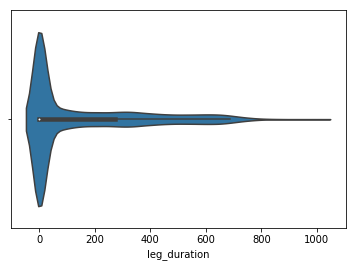

In [41]:
sns.violinplot(x=user_trips.toPandas()["leg_duration"])

In [42]:
user_trips.filter('leg_duration > 0').approxQuantile("leg_duration", [0.5], 0)

[281.0833333333333]

In [43]:
user_trips.write.csv(exp_data_folder_path + '/user_trips', header=True, mode='overwrite')

### Infer Destination Stops

In [44]:
user_trips_data = user_trips \
                .withColumn('o_date',F.from_unixtime(F.unix_timestamp(F.col('o_date'),'yyyy-MM-dd'), 'yyyy-MM-dd')) \
                .withColumn('next_o_date',F.from_unixtime(F.unix_timestamp(F.col('next_o_date'),'yyyy-MM-dd'), 'yyyy-MM-dd')) \
                .orderBy(['cardNum','o_date','o_timestamp'])

In [45]:
printdf(user_trips_data)

,o_route,o_bus_code,o_date,o_tripNum,o_timestamp,o_shape_id,o_shape_seq,o_shape_lat,o_shape_lon,o_stop_id,...,next_o_timestamp,next_o_shape_id,next_o_shape_seq,next_o_shape_lat,next_o_shape_lon,next_o_stop_id,next_o_boarding_id,o_unixtimestamp,next_o_unixtimestamp,leg_duration
0,628,HA251,2017-05-10,2,07:32:04,2055,6035109,-25.546812,-49.343321,35185,...,17:58:32,2899,6191373,-25.428445,-49.272962,29598,1443109011606,37924,75512,626.466667
1,901,MC302,2017-05-10,9,17:58:32,2899,6191373,-25.428445,-49.272962,29598,...,07:32:04,2055,6035109,-25.546812,-49.343321,35185,1434519076927,75512,37924,-1.000000
2,680,HA266,2017-05-10,2,07:03:52,3022,4525953,-25.582972,-49.328940,8239,...,17:47:17,2813,6221812,-25.420561,-49.268433,28882,1391569403940,36232,74837,643.416667
3,266,BN608,2017-05-10,14,17:47:17,2813,6221812,-25.420561,-49.268433,28882,...,07:03:52,3022,4525953,-25.582972,-49.328940,8239,403726925986,74837,36232,-1.000000
4,471,EC294,2017-05-10,1,06:00:06,1932,6355893,-25.489930,-49.225018,32158,...,07:28:44,2065,6487199,-25.519916,-49.278387,36109,1030792151228,32406,37724,88.633333
5,633,GA212,2017-05-10,4,07:28:44,2065,6487199,-25.519916,-49.278387,36109,...,06:00:06,1932,6355893,-25.489930,-49.225018,32158,1400159338612,37724,32406,-1.000000
6,870,BC598,2017-05-10,2,06:01:50,2247,5386363,-25.430770,-49.276242,29420,...,16:51:01,2115,6642380,-25.494003,-49.352445,35886,1322849927252,32510,71461,649.183333
7,658,JA026,2017-05-10,9,16:51:01,2115,6642380,-25.494003,-49.352445,35886,...,06:01:50,2247,5386363,-25.430770,-49.276242,29420,584115552383,71461,32510,-1.000000
8,779,JC864,2017-05-10,3,06:27:10,2904,5602243,-25.457090,-49.310536,33614,...,14:55:51,2953,3848606,-25.497289,-49.313547,36077,833223655624,34030,64551,508.683333
9,654,HA017,2017-05-10,13,14:55:51,2953,3848606,-25.497289,-49.313547,36077,...,06:27:10,2904,5602243,-25.457090,-49.310536,33614,154618822721,64551,34030,-1.000000


### Reading Bus Trip Data

In [46]:
printdf(filtered_boardings.limit(5))

,route,tripNum,shapeId,shapeSequence,shapeLat,shapeLon,distanceTraveledShape,busCode,gpsPointId,gpsLat,...,distanceToShapePoint,timestamp,stopPointId,problem,birthdate,cardTimestamp,lineName,cardNum,gender,date
0,547,15,4125,6165607,-25.541827,-49.264612,4097.772,GA142,None,-25.541680,...,31.689760,05:53:33,31271,NO_PROBLEM,22/04/63,05:54:23,V. SÃO PEDRO,431802,F,2017-05-10
1,828,1,2941,4249004,-25.460141,-49.340811,9660.000,LA001,None,-25.460058,...,9.355352,06:06:58,34257,NO_PROBLEM,28/05/63,06:07:54,C.COMP/C.RASO,433069,F,2017-05-10
2,777,11,2195,4299895,-25.442293,-49.269757,1126.717,JC006,None,-25.442241,...,7.728910,17:59:39,32903,NO_PROBLEM,03/02/93,18:00:33,V. VELHA,444810,F,2017-05-10
3,658,1,2115,6642358,-25.491613,-49.349015,2871.251,JA027,None,-25.491595,...,3.681068,06:18:32,35720,NO_PROBLEM,28/07/71,06:19:29,C.RASO/CAIUÁ,624028,M,2017-05-10
4,332,26,1864,5605729,-25.474949,-49.194635,4197.070,DA300,None,-25.474938,...,7.856321,15:16:37,32457,NO_PROBLEM,04/04/68,15:17:35,ACRÓPOLE,742198,F,2017-05-10


In [47]:
bus_trip_data = filtered_boardings.withColumn("gps_timestamp", F.concat(F.col("date"), F.lit(" "), F.col("timestamp")))
bus_trip_data = bus_trip_data.withColumn("gps_timestamp_in_secs", F.unix_timestamp(F.col("gps_timestamp"), "yyyy-MM-dd HH:mm:ss"))

In [48]:
bus_trip_data = bus_trip_data.orderBy(['route','busCode','tripNum','gps_timestamp_in_secs']) \
                            .dropDuplicates(['route','busCode','tripNum','stopPointId']) \
                            .drop('cardNum') \
                            .withColumn('id',F.monotonically_increasing_id()) \
                            .withColumn('route', F.col('route').cast(T.IntegerType())) \
                            .withColumnRenamed('','cardNum')

In [49]:
user_trips_data.printSchema()

root
 |-- o_route: string (nullable = true)
 |-- o_bus_code: string (nullable = true)
 |-- o_date: string (nullable = true)
 |-- o_tripNum: integer (nullable = true)
 |-- o_timestamp: string (nullable = true)
 |-- o_shape_id: integer (nullable = true)
 |-- o_shape_seq: integer (nullable = true)
 |-- o_shape_lat: double (nullable = true)
 |-- o_shape_lon: double (nullable = true)
 |-- o_stop_id: integer (nullable = true)
 |-- o_boarding_id: long (nullable = false)
 |-- cardNum: integer (nullable = true)
 |-- next_o_route: string (nullable = true)
 |-- next_o_bus_code: string (nullable = true)
 |-- next_o_date: string (nullable = true)
 |-- next_o_tripNum: integer (nullable = true)
 |-- next_o_timestamp: string (nullable = true)
 |-- next_o_shape_id: integer (nullable = true)
 |-- next_o_shape_seq: integer (nullable = true)
 |-- next_o_shape_lat: double (nullable = true)
 |-- next_o_shape_lon: double (nullable = true)
 |-- next_o_stop_id: integer (nullable = true)
 |-- next_o_boarding_id

In [50]:
bus_trip_data.printSchema()

root
 |-- route: integer (nullable = true)
 |-- tripNum: integer (nullable = true)
 |-- shapeId: integer (nullable = true)
 |-- shapeSequence: integer (nullable = true)
 |-- shapeLat: double (nullable = true)
 |-- shapeLon: double (nullable = true)
 |-- distanceTraveledShape: double (nullable = true)
 |-- busCode: string (nullable = true)
 |-- gpsPointId: string (nullable = true)
 |-- gpsLat: double (nullable = true)
 |-- gpsLon: double (nullable = true)
 |-- distanceToShapePoint: double (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- stopPointId: integer (nullable = true)
 |-- problem: string (nullable = true)
 |-- birthdate: string (nullable = true)
 |-- cardTimestamp: string (nullable = true)
 |-- lineName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- date: date (nullable = true)
 |-- gps_timestamp: string (nullable = true)
 |-- gps_timestamp_in_secs: long (nullable = true)
 |-- id: long (nullable = false)



In [51]:
cond = [bus_trip_data.route == user_trips_data.o_route, 
        bus_trip_data.busCode == user_trips_data.o_bus_code, 
        bus_trip_data.date == user_trips_data.o_date,
        bus_trip_data.tripNum == user_trips_data.o_tripNum]
od_trips = bus_trip_data.join(user_trips_data, cond, 'left_outer')

In [52]:
printdf(od_trips.orderBy(['route','busCode','tripNum','gps_timestamp_in_secs']))

,route,tripNum,shapeId,shapeSequence,shapeLat,shapeLon,distanceTraveledShape,busCode,gpsPointId,gpsLat,...,next_o_timestamp,next_o_shape_id,next_o_shape_seq,next_o_shape_lat,next_o_shape_lon,next_o_stop_id,next_o_boarding_id,o_unixtimestamp,next_o_unixtimestamp,leg_duration
0,1,1,2938,6451534,-25.428539,-49.267148,4546.136,BN997,None,-25.428566,...,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2,2938,6451403,-25.433455,-49.262219,972.378,BN997,None,-25.433371,...,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2,2938,6451490,-25.430831,-49.276405,3473.319,BN997,None,-25.430690,...,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,3,2938,6451385,-25.428133,-49.264531,338.081,BN997,None,-25.428088,...,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,3,2938,6451509,-25.429985,-49.271273,4070.474,BN997,None,NaN,...,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1,4,2938,6451385,-25.428133,-49.264531,338.081,BN997,None,-25.428031,...,07:17:37,1747.0,5995572.0,-25.470721,-49.289745,920.0,6.871948e+11,39172.0,37057.0,-1.00
6,1,4,2938,6451385,-25.428133,-49.264531,338.081,BN997,None,-25.428031,...,08:07:27,2069.0,6488697.0,-25.543032,-49.278421,34335.0,3.951370e+11,39174.0,40047.0,14.55
7,1,4,2938,6451394,-25.430622,-49.263426,635.815,BN997,None,-25.430811,...,07:17:37,1747.0,5995572.0,-25.470721,-49.289745,920.0,6.871948e+11,39172.0,37057.0,-1.00
8,1,4,2938,6451394,-25.430622,-49.263426,635.815,BN997,None,-25.430811,...,08:07:27,2069.0,6488697.0,-25.543032,-49.278421,34335.0,3.951370e+11,39174.0,40047.0,14.55
9,1,4,2938,6451475,-25.433142,-49.276703,3090.819,BN997,None,-25.433153,...,08:07:27,2069.0,6488697.0,-25.543032,-49.278421,34335.0,3.951370e+11,39174.0,40047.0,14.55


In [53]:
print od_trips.count()

983143


In [54]:
trips_with_boardings = od_trips
printdf(trips_with_boardings,l=100)

,route,tripNum,shapeId,shapeSequence,shapeLat,shapeLon,distanceTraveledShape,busCode,gpsPointId,gpsLat,...,next_o_timestamp,next_o_shape_id,next_o_shape_seq,next_o_shape_lat,next_o_shape_lon,next_o_stop_id,next_o_boarding_id,o_unixtimestamp,next_o_unixtimestamp,leg_duration
0,225,2,1798,6198127,-25.376546,-49.255613,1143.547,BA130,None,-25.376840,...,11:41:13,2935,6035123,-25.543671,-49.343730,35187,1365799600331,55057,52873,-1.000000
1,225,2,1798,6198127,-25.376546,-49.255613,1143.547,BA130,None,-25.376840,...,18:04:25,1979,6393338,-25.556785,-49.255025,36878,1013612282036,54965,75865,348.333333
2,225,2,1798,6198127,-25.376546,-49.255613,1143.547,BA130,None,-25.376840,...,14:44:35,3259,6011575,-25.435774,-49.306724,28132,1408749273383,54969,63875,148.433333
3,225,2,1798,6198127,-25.376546,-49.255613,1143.547,BA130,None,-25.376840,...,14:51:36,3770,6331308,-25.557031,-49.282289,37405,249108103211,56831,64296,124.416667
4,225,2,1798,6198127,-25.376546,-49.255613,1143.547,BA130,None,-25.376840,...,06:38:03,1715,6292571,-25.507935,-49.248863,32598,1056561955045,55842,34683,-1.000000
5,225,2,1798,6198127,-25.376546,-49.255613,1143.547,BA130,None,-25.376840,...,19:02:48,1886,6268112,-25.436471,-49.285002,29867,1151051235415,56328,79368,384.000000
6,225,2,1798,6198127,-25.376546,-49.255613,1143.547,BA130,None,-25.376840,...,06:28:15,2251,6065322,-25.414226,-49.334509,34661,51539607617,54954,34095,-1.000000
7,225,2,1798,6198127,-25.376546,-49.255613,1143.547,BA130,None,-25.376840,...,16:36:53,1785,5950730,-25.437541,-49.237840,30578,1606317768841,55512,70613,251.683333
8,225,2,1798,6198127,-25.376546,-49.255613,1143.547,BA130,None,-25.376840,...,12:35:43,2758,5996200,-25.406910,-49.271461,28816,1365799600274,56491,56143,-1.000000
9,225,2,1798,6198127,-25.376546,-49.255613,1143.547,BA130,None,-25.376840,...,13:07:12,2048,6196202,-25.507885,-49.304557,37799,824633721086,56486,58032,25.766667


In [55]:
def dist(lat_x, long_x, lat_y, long_y):
    return F.acos(
        F.sin(F.toRadians(lat_x)) * F.sin(F.toRadians(lat_y)) + 
        F.cos(F.toRadians(lat_x)) * F.cos(F.toRadians(lat_y)) * 
            F.cos(F.toRadians(long_x) - F.toRadians(long_y))
    ) * F.lit(6371.0)

In [56]:
trips_with_boardings = trips_with_boardings.withColumn('dist',dist(F.col('shapeLat'),F.col('shapeLon'),F.col('next_o_shape_lat'),F.col('next_o_shape_lon')))

In [57]:
printdf(trips_with_boardings,l=100)

,route,tripNum,shapeId,shapeSequence,shapeLat,shapeLon,distanceTraveledShape,busCode,gpsPointId,gpsLat,...,next_o_shape_id,next_o_shape_seq,next_o_shape_lat,next_o_shape_lon,next_o_stop_id,next_o_boarding_id,o_unixtimestamp,next_o_unixtimestamp,leg_duration,dist
0,225,2,1798,6198127,-25.376546,-49.255613,1143.547,BA130,None,-25.376840,...,2935,6035123,-25.543671,-49.343730,35187,1365799600331,55057,52873,-1.000000,20.581740
1,225,2,1798,6198127,-25.376546,-49.255613,1143.547,BA130,None,-25.376840,...,1979,6393338,-25.556785,-49.255025,36878,1013612282036,54965,75865,348.333333,20.041734
2,225,2,1798,6198127,-25.376546,-49.255613,1143.547,BA130,None,-25.376840,...,3259,6011575,-25.435774,-49.306724,28132,1408749273383,54969,63875,148.433333,8.350429
3,225,2,1798,6198127,-25.376546,-49.255613,1143.547,BA130,None,-25.376840,...,3770,6331308,-25.557031,-49.282289,37405,249108103211,56831,64296,124.416667,20.246976
4,225,2,1798,6198127,-25.376546,-49.255613,1143.547,BA130,None,-25.376840,...,1715,6292571,-25.507935,-49.248863,32598,1056561955045,55842,34683,-1.000000,14.625586
5,225,2,1798,6198127,-25.376546,-49.255613,1143.547,BA130,None,-25.376840,...,1886,6268112,-25.436471,-49.285002,29867,1151051235415,56328,79368,384.000000,7.287903
6,225,2,1798,6198127,-25.376546,-49.255613,1143.547,BA130,None,-25.376840,...,2251,6065322,-25.414226,-49.334509,34661,51539607617,54954,34095,-1.000000,8.964521
7,225,2,1798,6198127,-25.376546,-49.255613,1143.547,BA130,None,-25.376840,...,1785,5950730,-25.437541,-49.237840,30578,1606317768841,55512,70613,251.683333,7.013308
8,225,2,1798,6198127,-25.376546,-49.255613,1143.547,BA130,None,-25.376840,...,2758,5996200,-25.406910,-49.271461,28816,1365799600274,56491,56143,-1.000000,3.732918
9,225,2,1798,6198127,-25.376546,-49.255613,1143.547,BA130,None,-25.376840,...,2048,6196202,-25.507885,-49.304557,37799,824633721086,56486,58032,25.766667,15.408955


In [58]:
w = Window().partitionBy(['cardNum','date','route','busCode','tripNum']).orderBy('dist')

od_matrix = trips_with_boardings.filter('timestamp > o_timestamp') \
                    .withColumn('rn', F.row_number().over(w)) \
                    .where(F.col('rn') == 1)

In [59]:
printdf(od_matrix.select(['cardNum','route','tripNum','o_stop_id','o_timestamp','stopPointId','timestamp','dist']) \
                    .orderBy(['cardNum','o_timestamp']), l=100)

,cardNum,route,tripNum,o_stop_id,o_timestamp,stopPointId,timestamp,dist
0,306573,680,2,8239,07:03:52,31034,07:46:43,11.311857
1,306573,266,14,28882,17:47:17,30814,17:59:25,6.078259
2,313992,471,1,32158,06:00:06,32202,06:09:35,2.427015
3,313992,633,4,36109,07:28:44,31021,07:45:17,9.909206
4,317896,870,2,29420,06:01:50,29420,12:37:44,12.468102
5,317896,658,9,35886,16:51:01,35218,17:15:04,3.360628
6,321530,779,3,33614,06:27:10,34312,06:53:52,9.826164
7,321530,654,13,36077,14:55:51,27485,15:05:48,8.400315
8,321916,472,6,29702,08:06:15,26182,08:30:19,5.540679
9,321916,561,14,26152,18:30:42,30761,18:35:36,0.928266


In [60]:
printdf(od_matrix.select(['cardNum','o_stop_id','o_timestamp','stopPointId','timestamp','shapeLat','shapeLon','next_o_shape_lat','next_o_shape_lon','dist']) \
                    .orderBy(['cardNum','o_timestamp']), l=100)

,cardNum,o_stop_id,o_timestamp,stopPointId,timestamp,shapeLat,shapeLon,next_o_shape_lat,next_o_shape_lon,dist
0,306573,8239,07:03:52,31034,07:46:43,-25.512861,-49.294952,-25.450101,-49.206261,11.311857
1,306573,28882,17:47:17,30814,17:59:25,-25.405000,-49.263966,-25.458418,-49.251119,6.078259
2,313992,32158,06:00:06,32202,06:09:35,-25.468136,-49.240244,-25.452114,-49.223827,2.427015
3,313992,36109,07:28:44,31021,07:45:17,-25.512341,-49.294789,-25.427901,-49.263238,9.909206
4,317896,29420,06:01:50,29420,12:37:44,-25.430770,-49.276242,-25.541681,-49.294497,12.468102
5,317896,35886,16:51:01,35218,17:15:04,-25.492546,-49.296443,-25.466362,-49.279723,3.360628
6,321530,33614,06:27:10,34312,06:53:52,-25.464368,-49.309715,-25.516804,-49.230914,9.826164
7,321530,36077,14:55:51,27485,15:05:48,-25.492007,-49.293329,-25.447553,-49.225671,8.400315
8,321916,29702,08:06:15,26182,08:30:19,-25.435742,-49.271474,-25.459817,-49.319788,5.540679
9,321916,26152,18:30:42,30761,18:35:36,-25.442253,-49.268441,-25.435150,-49.273297,0.928266


In [61]:
printdf(od_matrix.describe('dist'))

,summary,dist
0,count,51417
1,mean,7.051686637317209
2,stddev,4.509266793049866
3,min,0.0
4,max,28.322212640027946


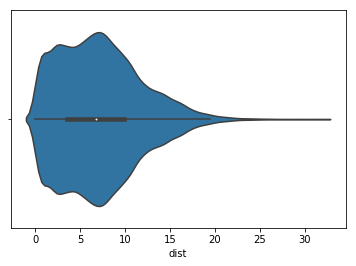

In [62]:
sns.violinplot(x=od_matrix.toPandas()["dist"])

In [63]:
inference_ok = 100*(od_matrix.filter('dist <= 1.0').count()/float(od_matrix.count()))
print "Percentage of trips with destionation satisfying threshold: ", inference_ok, "%"

Percentage of trips with destionation satisfying threshold:  7.37693758874 %


In [64]:
printdf(user_boardings.filter(((user_boardings.route == 916) & (user_boardings.tripNum == 8))) \
        .orderBy('timestamp'), l=100)

,route,tripNum,shapeId,shapeSequence,shapeLat,shapeLon,distanceTraveledShape,busCode,gpsPointId,gpsLat,...,distanceToShapePoint,timestamp,stopPointId,problem,birthdate,cardTimestamp,lineName,cardNum,gender,date
0,916,8,2893,6068354,-25.400911,-49.330169,0.000,MA002,None,-25.400930,...,2.491781,13:09:59,33126,NO_PROBLEM,None,None,None,NaN,None,2017-05-10
1,916,8,2273,4159067,-25.373298,-49.331735,198.390,MA007,None,NaN,...,NaN,13:12:07,33446,BETWEEN,None,None,None,NaN,None,2017-05-10
2,916,8,2273,4159080,-25.375819,-49.334449,589.579,MA007,None,-25.375781,...,4.504221,13:12:37,33443,NO_PROBLEM,None,None,None,NaN,None,2017-05-10
3,916,8,2273,4159088,-25.377074,-49.334534,768.393,MA007,None,-25.377118,...,14.073664,13:13:10,33436,NO_PROBLEM,None,13:13:31,PINHEIROS,10095128.0,,2017-05-10
4,916,8,2273,4159093,-25.378036,-49.333845,942.650,MA007,None,NaN,...,NaN,13:13:32,33433,BETWEEN,18/08/82,13:14:31,PINHEIROS,1275985.0,F,2017-05-10
5,916,8,2273,4159093,-25.378036,-49.333845,942.650,MA007,None,NaN,...,NaN,13:13:32,33433,BETWEEN,20/08/71,13:14:34,PINHEIROS,851402.0,M,2017-05-10
6,916,8,2273,4159093,-25.378036,-49.333845,942.650,MA007,None,NaN,...,NaN,13:13:32,33433,BETWEEN,13/10/02,13:14:42,PINHEIROS,3789520.0,F,2017-05-10
7,916,8,2273,4159093,-25.378036,-49.333845,942.650,MA007,None,NaN,...,NaN,13:13:32,33433,BETWEEN,11/08/87,13:14:28,PINHEIROS,3473358.0,F,2017-05-10
8,916,8,2273,4159093,-25.378036,-49.333845,942.650,MA007,None,NaN,...,NaN,13:13:32,33433,BETWEEN,20/03/78,13:14:51,PINHEIROS,1349468.0,M,2017-05-10
9,916,8,2273,4159093,-25.378036,-49.333845,942.650,MA007,None,NaN,...,NaN,13:13:32,33433,BETWEEN,09/01/95,13:14:55,PINHEIROS,3668242.0,M,2017-05-10


### Enriching BUSTE output with bus crowdedness information

In [65]:
trips_origins = od_matrix.filter(od_matrix.cardNum.isNotNull()) \
                            .select(['o_date','o_route','o_bus_code','o_tripNum','o_stop_id','o_timestamp']) \
                            .groupBy(['o_date','o_route','o_bus_code','o_tripNum','o_stop_id']) \
                            .count() \
                            .withColumnRenamed('count','boarding_cnt') \
                            .orderBy(['o_date','o_route','o_bus_code','o_tripNum'])

In [66]:
printdf(trips_origins, l=20)

,o_date,o_route,o_bus_code,o_tripNum,o_stop_id,boarding_cnt
0,2017-05-10,001,BN997,14,31453,1
1,2017-05-10,001,BN997,19,30749,1
2,2017-05-10,001,BN997,19,31453,1
3,2017-05-10,001,BN998,5,35216,1
4,2017-05-10,001,BN998,13,31453,1
5,2017-05-10,001,BN998,15,26375,1
6,2017-05-10,001,BN998,20,35219,1
7,2017-05-10,002,DN027,1,40029,1
8,2017-05-10,002,DN027,2,40030,1
9,2017-05-10,002,DN027,4,28603,1


In [67]:
trips_destinations = od_matrix.filter(od_matrix.cardNum.isNotNull()) \
                            .select(['date','route','busCode','tripNum','stopPointId','timestamp']) \
                            .groupBy(['date','route','busCode','tripNum','stopPointId']) \
                            .count() \
                            .orderBy(['date','route','busCode','tripNum'])

In [73]:
trips_destinations = rename_columns(
                        trips_destinations,
                        [('date','d_date'),
                         ('route','d_route'),
                         ('busCode','d_bus_code'),
                         ('tripNum','d_tripNum'),
                         ('stopPointId','d_stop_id'),
                         ('count','alighting_cnt')])

In [74]:
printdf(trips_destinations, l=20)

,d_date,d_route,d_bus_code,d_tripNum,d_stop_id,alighting_cnt
0,2017-05-10,1,BN997,14,26375,1
1,2017-05-10,1,BN997,19,26375,2
2,2017-05-10,1,BN998,5,26375,1
3,2017-05-10,1,BN998,13,35219,1
4,2017-05-10,1,BN998,15,26375,1
5,2017-05-10,1,BN998,20,26375,1
6,2017-05-10,2,DN027,1,31458,1
7,2017-05-10,2,DN027,2,31458,1
8,2017-05-10,2,DN027,4,40030,1
9,2017-05-10,2,DN027,9,29917,2


In [75]:
origin_cond = [bus_trip_data.date == trips_origins.o_date,
               bus_trip_data.route == trips_origins.o_route, 
               bus_trip_data.busCode == trips_origins.o_bus_code, 
               bus_trip_data.tripNum == trips_origins.o_tripNum,
               bus_trip_data.stopPointId == trips_origins.o_stop_id
]

dest_cond = [bus_trip_data.date == trips_destinations.d_date,
               bus_trip_data.route == trips_destinations.d_route, 
               bus_trip_data.busCode == trips_destinations.d_bus_code, 
               bus_trip_data.tripNum == trips_destinations.d_tripNum,
               bus_trip_data.stopPointId == trips_destinations.d_stop_id
]


buste_crowdedness = bus_trip_data.join(trips_origins,origin_cond,'left_outer') \
                        .join(trips_destinations,dest_cond,'left_outer') \
                        .drop('o_date','o_route','o_bus_code','o_tripNum','o_stop_id') \
                        .drop('d_date','d_route','d_bus_code','d_tripNum','d_stop_id') \
                        .withColumn('boarding_cnt',F.when(F.col('boarding_cnt').isNull(),F.lit(0)).otherwise(F.col('boarding_cnt'))) \
                        .withColumn('alighting_cnt',F.when(F.col('alighting_cnt').isNull(),F.lit(0)).otherwise(F.col('alighting_cnt'))) \

In [76]:
printdf(buste_crowdedness.filter(buste_crowdedness.boarding_cnt > 0))

,route,tripNum,shapeId,shapeSequence,shapeLat,shapeLon,distanceTraveledShape,busCode,gpsPointId,gpsLat,...,birthdate,cardTimestamp,lineName,gender,date,gps_timestamp,gps_timestamp_in_secs,id,boarding_cnt,alighting_cnt
0,20,1,3259,6011566,-25.439439,-49.307043,28268.066,BB607,None,-25.439486,...,15/01/52,06:41:23,INTERBAIRR II H,F,2017-05-10,2017-05-10 06:40:43,1494409243,687194767367,1,0
1,20,5,3259,6011417,-25.494636,-49.285328,19725.154,BB607,None,-25.494570,...,13/07/71,15:37:24,INTERBAIRR II H,M,2017-05-10,2017-05-10 15:36:54,1494441414,1194000908296,1,0
2,20,2,3264,6008378,-25.459772,-49.301920,4900.884,BR107,None,-25.459165,...,09/09/68,07:49:36,INTERBAIRR II H,F,2017-05-10,2017-05-10 07:49:10,1494413350,532575944713,1,0
3,20,4,3260,6012264,-25.459771,-49.301920,16996.322,CB604,None,-25.459043,...,30/03/64,14:06:53,INTERBAIRR II H,F,2017-05-10,2017-05-10 14:06:18,1494435978,249108103177,1,0
4,20,5,3260,6012603,-25.395535,-49.250880,30982.370,CB604,None,-25.395570,...,29/10/85,17:15:49,INTERBAIRR II H,F,2017-05-10,2017-05-10 17:15:19,1494447319,687194767372,1,2
5,20,2,3261,6013210,-25.397139,-49.287976,19981.293,HB601,None,-25.397123,...,14/05/96,09:08:20,INTERBAIRR II H,F,2017-05-10,2017-05-10 09:07:22,1494418042,798863917071,2,0
6,21,5,3263,5215245,-25.401445,-49.253120,750.673,BB600,None,-25.401481,...,15/07/00,14:43:16,INTERB II ANTI H,F,2017-05-10,2017-05-10 14:43:10,1494438190,652835029006,1,0
7,21,2,3263,5215517,-25.422412,-49.292449,10019.879,BB601,None,-25.422550,...,02/01/94,08:54:57,INTERB II ANTI H,M,2017-05-10,2017-05-10 08:54:16,1494417256,386547056655,1,3
8,21,1,3269,5234085,-25.413484,-49.290649,24291.982,DR102,None,NaN,...,04/05/78,06:31:21,INTERB II ANTI H,F,2017-05-10,2017-05-10 06:30:40,1494408640,231928233998,1,0
9,21,3,3269,5233783,-25.417721,-49.243811,13149.749,DR102,None,-25.417623,...,08/12/75,10:46:02,INTERB II ANTI H,F,2017-05-10,2017-05-10 10:45:51,1494423951,214748364825,1,0


In [77]:
trips_window = Window.partitionBy(['date','route','busCode','tripNum']).orderBy('timestamp')

buste_crowdedness = buste_crowdedness.withColumn('crowd_bal', F.col('boarding_cnt') - F.col('alighting_cnt')) \
                        .withColumn('num_pass',F.sum('crowd_bal').over(trips_window)) \
                        .drop('numPassengers','gps_timestamp','gps_timestamp_in_secs') \
                        .orderBy(['date','route','busCode','tripNum','timestamp'])                        

In [78]:
printdf(buste_crowdedness.select(['date','route','busCode','tripNum','stopPointId','timestamp','boarding_cnt','alighting_cnt','crowd_bal','num_pass']) \
                           .orderBy(['date','route','busCode','tripNum','timestamp'])
       ,l=100)

,date,route,busCode,tripNum,stopPointId,timestamp,boarding_cnt,alighting_cnt,crowd_bal,num_pass
0,2017-05-10,1,BN997,1,26360,06:41:44,0,0,0,0
1,2017-05-10,1,BN997,2,31454,06:49:45,0,0,0,0
2,2017-05-10,1,BN997,2,29420,07:00:16,0,0,0,0
3,2017-05-10,1,BN997,3,29887,07:13:25,0,0,0,0
4,2017-05-10,1,BN997,3,26375,07:30:34,0,0,0,0
5,2017-05-10,1,BN997,4,29887,07:38:36,0,0,0,0
6,2017-05-10,1,BN997,4,31453,07:40:10,0,0,0,0
7,2017-05-10,1,BN997,4,35219,07:51:57,0,0,0,0
8,2017-05-10,1,BN997,5,31453,08:05:48,0,0,0,0
9,2017-05-10,1,BN997,7,31453,08:58:09,0,0,0,0


In [79]:
buste_crowdedness.write.csv(path=exp_data_folder_path+'/buste_crowdedness',header=True, mode='overwrite')